# Example 1: Applying an automatic error detection algorithm to a timeseries
_Created by Davíd Brakenhoff, Artesia, May 2020_

<hr>

This notebook contains a simple example how to set up an automatic error detection algorithm based on a few simple rules and applies those rules to a groundwater timeseries.

First import the requisite packages:

In [1]:
import os
import numpy as np
import pandas as pd

import traval
from traval import rulelib as rlib

## Data
Load the data. The following information is available:
- The raw groundwater levels (with all the measurement errors still in the timeseries).
- The manually validated timeseries (this is what we consider as the 'truth'). Of course the manual validation isn't always perfect, but since it's all we have to compare with we're using this as our 'truth'. We assume our manual validation is good, so hopefully our error detection algorithm yields similar results to the manual validation. 
- The sensor level in meters relative to NAP, for checking whether the sensor is above the groundwater level.
- The elevation of the top of the piezometer, for checking whether the groundwater level is above this level.

In [2]:
datadir = "../data/"
raw = pd.read_csv(os.path.join(datadir, "raw_series.csv"), index_col=[0], parse_dates=True).squeeze()
truth = pd.read_csv(os.path.join(datadir, "manual_validation_series.csv"), index_col=[0], parse_dates=True).squeeze()
truth.name = "manual validation"
sensor_level = pd.read_csv(os.path.join(datadir, "sensor_level_nap.csv"), index_col=[0], parse_dates=True).squeeze()
top_piezometer = pd.read_csv(os.path.join(datadir, "top_piezometer_level.csv"), index_col=[0], parse_dates=True).squeeze()

## The error detection algorithm and the `RuleSet` object
The detection algorithm consists of 3 checks and an extra step to combine the results of those three checks:
1. Check for spikes (when groundwater level suddenly changes and returns to its original level one timestep later).
2. Check if sensor is above groundwater level.
3. Check if groundwater level is above top of piezometer (if the piezometer is closed this is possible, but in this case we know it isn't).
4. Combine the results of checks 1 to 3 to yield the final result.

The error detection algorithm is entered using the `RuleSet` object. This is an object that can hold any number of error detection rules and apply those to a timeseries. With the `RuleSet.add_rule()` method, rules can be added to the algorithm. Ading a rule requires the following input:
- **name**: name of the rule (user-specified)
- **func**: the function to apply to the timeseries
- **apply_to**: an integer indicating to which timeseries the rule should be applied. The original timeseries is 0, the outcome from step 1 is 1, etc.
- **kwargs**: a dictionary containing any other arguments required by the functions that are passed.

The final rule we add doesn't check for errors but combines the results from the previous three steps to create one final timeseries that includes the outcome from each of the preceding rules. In this case `apply_to` is a tuple of ints referencing the results that should be combined. In this case it says to combine the results from steps 1, 2 and 3.

In [4]:
# initialize RuleSet object
rset = traval.RuleSet(name="basic")

# add rules
rset.add_rule("spikes", rlib.rule_spike_detection, apply_to=0, 
              kwargs={"threshold": 0.15, "spike_tol": 0.15, "max_gap": "7D"})
rset.add_rule("dry", rlib.rule_ufunc_threshold, apply_to=0, 
              kwargs={"ufunc": (np.less,), "threshold": sensor_level, "offset": 0.025})
rset.add_rule("hardmax", rlib.rule_ufunc_threshold, apply_to=0, 
              kwargs={"ufunc": (np.greater,), "threshold": top_piezometer})
rset.add_rule("combine", rlib.rule_combine_nan_or, apply_to=(1, 2, 3))

The view of the object shows which rules have been added:

In [5]:
# view object
rset

RuleSet: 'basic'
  step: name            apply_to
     1: spikes                 0
     2: dry                    0
     3: hardmax                0
     4: combine         (1, 2, 3)

The `RuleSet` object can be stored as pickle file or as JSON. 
- `to_pickle`: This option has full support for custom functions and is the most flexible and is therefore recommended. The file is not human readable however.
- `to_json`: Storing as a JSON file has the advantage of creating a human readable file, but it only supports default functions from `traval.rulelib`. So custom functions will not be preserved when saving in this format.

In [6]:
rset.to_pickle('test.pkl')
rset2 = traval.RuleSet.from_pickle("test.pkl")

RuleSet written to file: 'test.pkl'


In [7]:
rset.to_json("test.json")
rset3 = traval.RuleSet.from_json("test.json")

RuleSet written to file: 'test.json'


/home/david/Github/traval/traval/ruleset.py:436: UserWarning: Custom functions will not be preserved when storing RuleSet as JSON file!
  warnings.warn(msg)


Delete the two files we just created.

In [8]:
for f in ["test.json", "test.pkl"]:
    os.remove(f)

## The `Detector` object

The `Detector` object provides tools for storing a timeseries, applying an algorithm built with the `RuleSet` object and processing the outcomes. We initialize the objet with the raw data timeseries in which we want to find the erroneous measurements. Optionally we can add a "truth" series to compare the outcome of our error detection algorithm to.

In [9]:
detector = traval.Detector(raw, truth=truth)
detector

Detector: <DEUR033_G>

Apply our custom algorithm. The `compare=True` creates `SeriesComparison` objects for the result of each step in the algorithm. These objects compare the result of a error detection step with the original timeseries or the 'truth' if available. The object also includes methods to plot the comparison results.

In [10]:
detector.apply_ruleset(rset, compare=True)

Plot an overview of the results. This creates one plot per rule and highlights which points were marked as suspect based on that rule.

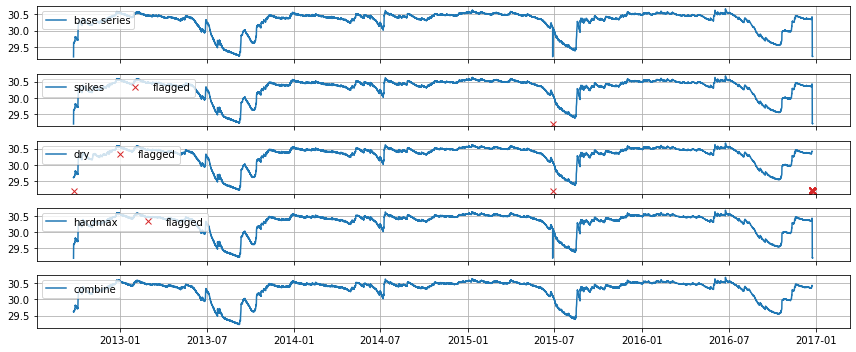

In [11]:
axes = detector.plot_overview()

The results with the flagged values as NaNs in the original series can be obtained with `detector.get_results_dataframe()`.

In [12]:
results = detector.get_results_dataframe()
results.head()

,base series,spikes,dry,hardmax,combine
index,,,,,
2012-09-24 15:00:00,29.1959,29.1959,NaN,29.1959,NaN
2012-09-24 16:00:00,29.6104,29.6104,29.6104,29.6104,29.6104
2012-09-24 17:00:00,29.6082,29.6082,29.6082,29.6082,29.6082
2012-09-24 18:00:00,29.6170,29.6170,29.6170,29.6170,29.6170
2012-09-24 19:00:00,29.6158,29.6158,29.6158,29.6158,29.6158


The corrections are only stored for timestamps where corrections were deemed relevant.

In [13]:
corrections = detector.get_corrections_dataframe()
corrections

,spikes,dry,hardmax,combine
2012-09-24 15:00:00,0.0,NaN,0.0,0.0
2015-06-27 14:30:41,NaN,NaN,0.0,0.0
2016-12-23 10:00:00,0.0,NaN,0.0,0.0
2016-12-23 11:00:00,0.0,NaN,0.0,0.0
2016-12-23 12:00:00,0.0,NaN,0.0,0.0
2016-12-23 13:00:00,0.0,NaN,0.0,0.0
2016-12-23 14:00:00,0.0,NaN,0.0,0.0
2016-12-23 15:00:00,0.0,NaN,0.0,0.0
2016-12-23 16:00:00,0.0,NaN,0.0,0.0
2016-12-23 17:00:00,0.0,NaN,0.0,0.0


The comparison objects are stored as a dictionary under `detector.comparisons`:

In [14]:
detect = detector

In [15]:
detect.comparisons

{1: <traval.ts_comparison.SeriesComparisonRelative at 0x7f670b7b3890>,
 2: <traval.ts_comparison.SeriesComparisonRelative at 0x7f66e2fab7d0>,
 3: <traval.ts_comparison.SeriesComparisonRelative at 0x7f66e2fab4d0>,
 4: <traval.ts_comparison.SeriesComparisonRelative at 0x7f66e2fb73d0>}

Let's take a look at the comparison of the final result with manual validation, relative to the raw data.

In [16]:
comp = detector.comparisons[4]

The `SeriesComparisonRelative` object contains a summary of the different categories measurements can fall into, e.g. "kept in both" means the observations was deemed valid in both the detection result and the "truth" timeseries.

In [17]:
comp.summary_base_comparison

kept_in_both          37212
flagged_in_s1             0
flagged_in_s2             0
flagged_in_both          25
in_all_nan                0
introduced_in_s1          0
introduced_in_s2          0
introduced_in_both        0
Name: N_obs, dtype: int64

Plot the comparison overview. In this comparison the manual validation and the result of our error detection algorithm are compared to each other relative to the raw data. In this case we can see that all the points that were marked as suspect in the manual validation were also identified by our algorithm.

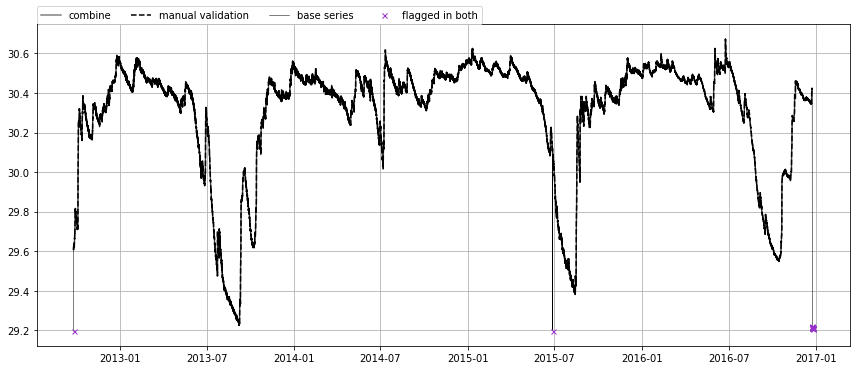

In [18]:
ax = comp.plots.plot_relative_comparison(mark_different=False, mark_identical=False)
leg = ax.legend(loc=(0, 1), ncol=4)

## Binary Classification statistics and the confusion matrix
All methods for calculating statistics related to binary classification are available through the `comp.bc` attribute. 

In [19]:
comp.bc?

Type:           BinaryClassifier
String form:    <traval.binary_classifier.BinaryClassifier object at 0x7f66e2fb9850>
File:           ~/Github/traval/traval/binary_classifier.py
Docstring:      Class for calculating binary classification statistics.
Init docstring:
Initialize class for calculating binary classification statistics.

Parameters
----------
tp : int
    number of True Positives (TP)
fp : int
    number of False Positives (FP)
tn : int
    number of True Negatives (TN)
fn : int
    number of False Negatives (FN)


The `comp.bc.confustion_matrix` method is used to calculate the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The number of times the algorithm is correct (as compared to the "truth") is given on the diagonal. The number of times the algorithm is wrong is shown outside the diagonal.

In [20]:
comp.bc.confusion_matrix?

Signature: comp.bc.confusion_matrix(as_array=False)
Docstring:
Calculate confusion matrix.

Confusion matrix shows the performance of the algorithm given a
certain truth. An abstract example of the confusion matrix:

                |     Algorithm     |
                |-------------------|
                |  error  | correct |
------|---------|---------|---------|
      |  error  |   TP    |   FN    |
Truth |---------|---------|---------|
      | correct |   FP    |   TN    |
------|---------|---------|---------|

where:
- TP: True Positives  = errors correctly detected by algorithm
- TN: True Negatives  = correct values correctly not flagged by algorithm
- FP: False Positives = correct values marked as errors by algorithm
- FN: False Negatives = errors not detected by algorithm

Parameters
----------
as_array : bool, optional
    return data as array instead of DataFrame, by default False

Returns
-------
data : pd.DataFrame or np.array
    confusion matrix
File:      ~/Github/trava

In [21]:
cmat = comp.bc.confusion_matrix()
cmat

Algorithm        
                    error correct
"Truth" error          25       0
        correct         0   37212

Binary classification statistics are also available:
- **sensitivity** or **true positive rate**: number of positives identified relative to total number of positives. This says something about the avoidance of false negatives.
- **specificity** or **true negative rate**: number of negatives identified relative to total number of negatives. This says something about the avoidance of false positives.
- **false positive rate**: (= 1 - specificity)
- **false negative rate**: (= 1 - sensitivity)

More explanation is available in de docstrings of these properties:

In [22]:
comp.bc.specificity?

Type:        property
String form: <property object at 0x7f66e3d4e2f0>
Docstring:  
Specificity or True Negative Rate.

Statistic describing ratio of true negatives identified,
which also says something about the avoidance of false positives.

    Specificity = TN / (TN + FP)

where
- TN : True Negatives
- FP : False Positives


In [23]:
print(f"- True Positive Rate  = {comp.bc.true_positive_rate} =       Sensitivity = {comp.bc.sensitivity}")
print(f"- True Negative Rate  = {comp.bc.true_negative_rate} =       Specificity = {comp.bc.specificity}")
print(f"- False Positive Rate = {comp.bc.false_positive_rate} = (1 - Specificity) = {1 - comp.bc.specificity}")
print(f"- False Negative Rate = {comp.bc.false_negative_rate} = (1 - Sensitivity) = {1 - comp.bc.sensitivity}")

- True Positive Rate  = 1.0 =       Sensitivity = 1.0
- True Negative Rate  = 1.0 =       Specificity = 1.0
- False Positive Rate = 0.0 = (1 - Specificity) = 0.0
- False Negative Rate = 0.0 = (1 - Sensitivity) = 0.0


Matthews Correlation Coefficient (MCC) 

The MCC is seen as a balanced measure for classification that also works when classes have very different sizes. It is essentially a measure between -1 and 1 that attempts to summarize the confusion matrix in one value. A coefficient of +1 represents a perfect prediction, 0 no better than random prediction and −1 indicates total disagreement between prediction and observation. Though there is no perfect way of summarizing the confusion matrix in one measure, the MCC is seen as one of the best of such measures (Source: [Wikipedia](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient)).

In [25]:
comp.bc.mcc

1.0

## Receiver Operator Characteristic plot
Finally, we can plot the so-called "receiver operator characteristic curve", which shows the performance of our algorithm relative to the line corresponding to a random guess. The plot shows the False Positive Rate versus the True Positive Rate. The higher the True Positive Rate the better our algorithm is able to identify errors. The lower the False Positive Rate, the lower the number of False Positives it yields. The perfect score is therefore the top left corner of the plot. 

Our algorithm scores perfectly in this example.

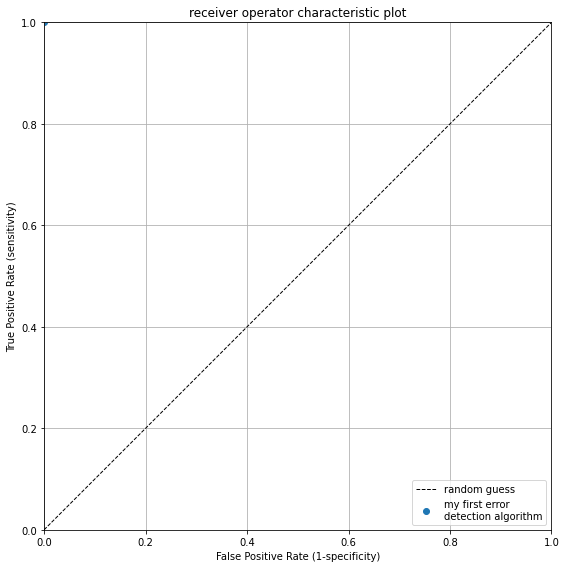

In [29]:
label = "my first error \ndetection algorithm"
ax = traval.plots.roc_plot(comp.bc.true_positive_rate, 
                           comp.bc.false_positive_rate, 
                           labels=label)